<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/experiments/test_large_batch_optimezer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade torch


# Imports

In [2]:
import torch
import argparse
from torch.optim.optimizer import Optimizer, required
import torch
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import json
from PIL import Image
import math
import torch.nn as nn
import torch.nn.functional as F
import copy
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR, LambdaLR
import matplotlib.pyplot as plt
import time
from torch.amp import GradScaler, autocast
import os
from google.colab import drive

In [3]:
drive.mount('/content/drive')
if not os.path.exists('/content/drive/MyDrive'):
    raise RuntimeError("Google Drive not mounted correctly!")

Mounted at /content/drive


## Costants

In [4]:
BATCH_SIZE = 64

## Model

In [5]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)

        # Layer fully connected
        self.fc1 = nn.Linear(64 * 5 * 5, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        # Layer convolutivi con ReLU e max-pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        # Flatten per i layer fully connected
        x = torch.flatten(x, 1)

        # Layer fully connected con ReLU
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)

        return x

## Training function

In [6]:
def train_model_with_hyperparams(train_loader, val_loader, test_loader, hyperparams, num_epochs, device, checkpoint_path, type_of_optimizer, batch_size, train_dataset):
    model = LeNet5().to(device)

    if type_of_optimizer == "SGDM":
        if hyperparams.get('momentum', None) is None:
            raise ValueError("Momentum is required for SGDM")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for SGDM")
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for SGDM")

        optimizer = optim.SGD(
            model.parameters(),
            lr=hyperparams['lr'],
            momentum=hyperparams['momentum'],
            weight_decay=hyperparams['weight_decay']
        )

    elif type_of_optimizer == "AdamW":
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for AdamW")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for AdamW")

        optimizer = optim.AdamW(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
            #eps=hyperparams['eps']
        )

    elif type_of_optimizer == "LAMB":
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for LAMB")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for LAMB")

        optimizer = LAMB(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
        )

    elif type_of_optimizer == "LARS":
        if hyperparams.get('lr', None) is None:
            raise ValueError("Learning rate is required for LARS")
        if hyperparams.get('weight_decay', None) is None:
            raise ValueError("Weight decay is required for LARS")

        optimizer = LARS(
            model.parameters(),
            lr=hyperparams['lr'],
            weight_decay=hyperparams['weight_decay'],
        )
    else:
        raise ValueError("Invalid optimizer type")


    iterations_per_epoch = len(train_dataset) // batch_size

    warmup_epoch = 5

    def warmup_scheduler_fn(epoch):
        if epoch < warmup_epoch:
            return float(epoch+1) / warmup_epoch
        return 1.0


    warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_scheduler_fn)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs - warmup_epoch)

    import time
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    save_path = f"/content/drive/My Drive/Colab Notebooks/Traning_summary/Batch_Size_Comparison_{timestamp}"
    os.makedirs(save_path, exist_ok=True)

    metrics_files = {
        'train_acc': os.path.join(save_path, f'{type_of_optimizer}_train_accuracy_{timestamp}_{str(batch_size)}.txt'),
        'val_acc': os.path.join(save_path, f'{type_of_optimizer}_val_accuracy_{timestamp}_{str(batch_size)}.txt'),
        'train_loss': os.path.join(save_path, f'{type_of_optimizer}_train_loss_{timestamp}_{str(batch_size)}.txt'),
        'val_loss': os.path.join(save_path, f'{type_of_optimizer}_val_loss_{timestamp}_{str(batch_size)}.txt')
    }

    # Crea un file di configurazione per salvare i parametri dell'esperimento
    with open(os.path.join(save_path, f'{type_of_optimizer}_experiment_config_{timestamp}_{str(batch_size)}.txt'), 'w') as f:
        f.write(f"Experiment Configuration:\n")
        f.write(f"Optimizer: {type_of_optimizer}\n")
        f.write(f"Hyperparameters: {str(hyperparams)}\n")
        f.write(f"Number of epochs: {num_epochs}\n")
        f.write(f"Timestamp: {timestamp}\n")


    criterion = nn.CrossEntropyLoss()

    start_epoch = 0

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_model = None
    best_val_loss = 0.0
    for epoch in range(num_epochs):
        model.train()
        train_loss_total, train_correct, train_total = 0, 0, 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss_total += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        train_loss = train_loss_total / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation loop
        model.eval()
        val_loss_total, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss_total += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss_total / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        try:
            with open(metrics_files['train_acc'], 'a') as f:
                f.write(f"{epoch + 1},{train_acc:.4f}\n")
            with open(metrics_files['val_acc'], 'a') as f:
                f.write(f"{epoch + 1},{val_acc:.4f}\n")
            with open(metrics_files['train_loss'], 'a') as f:
                f.write(f"{epoch + 1},{train_loss:.4f}\n")
            with open(metrics_files['val_loss'], 'a') as f:
                f.write(f"{epoch + 1},{val_loss:.4f}\n")
        except Exception as e:
            print(f"Error saving metrics: {e}")

        print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Epoch {epoch + 1}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())

        if epoch < warmup_epoch:
            warmup_scheduler.step()
        else:
            scheduler.step()


    if best_model is not None:
        model.load_state_dict(best_model)
    # Test loop
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            outputs = model(inputs)

            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_acc = 100. * test_correct / test_total
    print(f"Final Test Accuracy: {test_acc:.2f}%")
    return train_losses, val_losses, train_accuracies, val_accuracies, test_acc

## Defining different optimizers

In [7]:
class LARS(Optimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, batch_size=32, weight_decay=1e-4, epsilon=1e-8):
        defaults = dict(lr=lr, beta1=beta1, batch_size=batch_size,
                       weight_decay=weight_decay, epsilon=epsilon)
        super(LARS, self).__init__(params, defaults)

        # Initialize momentum
        self.m0 = {param: torch.zeros_like(param.data) for group in self.param_groups
                   for param in group['params']}

    def phi(self, norm):
        """Scaling function φ as defined in the paper"""
        return torch.ones_like(norm)  # Can be modified for different scaling strategies

    def get_batch_samples(self, dataset, batch_size):
        """Draw b samples from the dataset"""
        indices = torch.randperm(len(dataset))[:batch_size]
        return [dataset[i] for i in indices]

    @torch.no_grad()
    def step(self, closure=None, dataset=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            beta1 = group['beta1']
            lr = group['lr']
            weight_decay = group['weight_decay']
            epsilon = group['epsilon']

            # Draw batch samples if dataset provided
            if dataset is not None:
                batch = self.get_batch_samples(dataset, group['batch_size'])

            for param in group['params']:
                if param.grad is None:
                    continue

                grad = param.grad
                state = self.state[param]

                # Compute gt (gradient plus weight decay)
                gt = grad + weight_decay * param.data

                # Update momentum mt
                if 'momentum' not in state:
                    state['momentum'] = torch.zeros_like(param.data)
                mt = state['momentum']
                mt.mul_(beta1).add_((1 - beta1) * (gt + weight_decay * param.data))

                # Compute the update with φ scaling
                param_norm = param.data.norm(2).clamp(min=epsilon)
                mt_norm = mt.norm(2).clamp(min=epsilon)

                update = lr * (self.phi(param_norm) / mt_norm) * mt

                # Update parameters
                param.data.sub_(update)

        return loss


class LAMB(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta1 parameter: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta2 parameter: {betas[1]}")

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad
                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # m_t = β₁m_{t-1} + (1-β₁)g_t
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                # v_t = β₂v_{t-1} + (1-β₂)g_t²
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Bias correction
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # m̂_t = m_t/(1-β₁ᵗ)
                exp_avg_hat = exp_avg / bias_correction1
                # v̂_t = v_t/(1-β₂ᵗ)
                exp_avg_sq_hat = exp_avg_sq / bias_correction2

                # r_t = m̂_t/√(v̂_t + ε)
                denom = exp_avg_sq_hat.sqrt().add_(group['eps'])
                update = exp_avg_hat / denom

                # r_t + λx_t
                if group['weight_decay'] > 0:
                    update.add_(p.data, alpha=group['weight_decay'])

                # Compute trust ratio φ(‖x_t‖)/‖r_t + λx_t‖
                w_norm = p.data.norm(p=2)
                g_norm = update.norm(p=2)
                trust_ratio = torch.where(
                    w_norm > 0,
                    w_norm / (g_norm + group['eps']),
                    torch.ones_like(w_norm)
                )

                # x_{t+1} = x_t - η·trust_ratio·(r_t + λx_t)
                p.data.add_(update, alpha=-group['lr'] * trust_ratio)
        return loss

In [8]:
def parse_args():
    parser = argparse.ArgumentParser(description='Large-Batch Optimizer Selection')
    parser.add_argument('--optimizer', type=str, default='SGDM', choices=['SGDM', 'AdamW', 'LARS', 'LAMB'],
                        help='Select optimizer (SGDM, AdamW, LARS, LAMB)')
    #parser.add_argument('--lr', type=float, default=1e-3, help='Learning rate')
    #parser.add_argument('--batch_size', type=int, default=32, help='Batch size')
    args = parser.parse_args()
    return args


## Function to get train, test and val dataset

In [9]:
def get_dataset(batch_size=100):

    print("batch_size", batch_size)
    # Define the transform to only convert the images to tensors (without normalization yet)
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load the CIFAR-100 training dataset
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=False, num_workers=2)

    # Initialize sums for calculating mean and std
    mean = torch.zeros(3)
    std = torch.zeros(3)

    for images, _ in train_loader:
        # Compute mean and std for each channel
        mean += images.mean(dim=[0, 2, 3])
        std += images.std(dim=[0, 2, 3])

    mean /= len(train_loader)
    std /= len(train_loader)

    print("Mean: ", mean)
    print("Std: ", std)

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    transform_test = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean[0].item(), mean[1].item(), mean[2].item()],
                            std=[std[0].item(), std[1].item(), std[2].item()])
    ])

    # Load CIFAR-100 dataset
    start_time = time.time()
    train_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR100(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )
    print(f"Dataset loading time: {time.time() - start_time:.2f} seconds")

    # Split training and validation sets
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Data loaders
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Debugging: Check DataLoader outputs
    for i, (inputs, labels) in enumerate(train_loader):
        print(f"Batch {i}: inputs shape: {inputs.shape}, labels shape: {labels.shape}")
        if i == 10:  # Test first 10 batches
            break
    print(f"Data loading for 10 batches completed.")

    return train_dataset, train_loader, val_loader, test_loader

## Main

batch_size 128


100%|██████████| 169M/169M [00:03<00:00, 48.8MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Mean:  tensor([0.5071, 0.4865, 0.4409])
Std:  tensor([0.2667, 0.2558, 0.2754])
Files already downloaded and verified
Files already downloaded and verified
Dataset loading time: 1.76 seconds
Batch 0: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 1: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 2: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 3: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 4: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 5: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 6: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 7: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size([128])
Batch 8: inputs shape: torch.Size([128, 3, 32, 32]), labels shape: torch.Size(

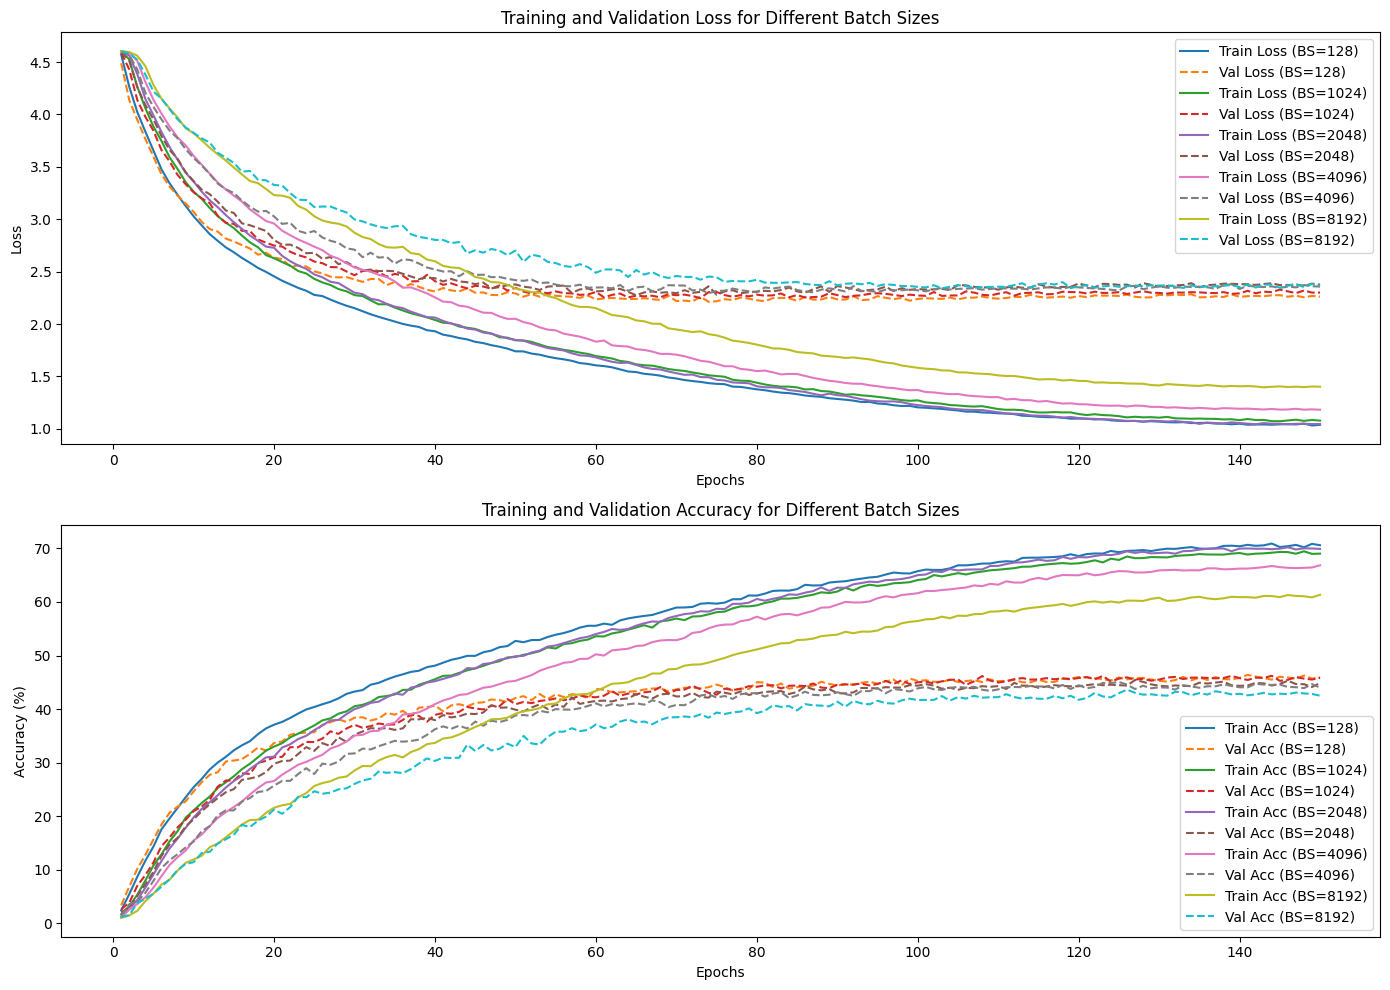

Training summaries saved to Google Drive as 'Batch_Size_Comparison_summary.txt'


In [10]:
if __name__ == "__main__":

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #args = parse_args()

    class Args:
        def __init__(self):
            self.optimizer = 'LAMB'  # Choose from: 'SGDM', 'AdamW', 'LARS', 'LAMB'
            #self.batch_size = 32

    args = Args() # replace "args = parse_args()" with this line


    all_train_losses = {}
    all_val_losses = {}
    all_train_accuracies = {}
    all_val_accuracies = {}
    all_test_accuracies = {}

    batch_sizes = [128, 1024, 2048, 4096, 8192]

    for batch_size in batch_sizes:

        train_dataset, train_loader, val_loader, test_loader = get_dataset(batch_size)

        base_lr = 0.001
        base_batch_size = 64
        # square root scaling rule
        lr = base_lr * math.sqrt(batch_size/base_batch_size)

        hyperparams = {
            'lr': lr,
            'weight_decay': 0.1,
            'patience': 100
        }

        print(f"Using hyperparams: lr: {hyperparams['lr']}, weight_decay: {hyperparams['weight_decay']}")

        # Train with the best hyperparameters
        train_losses, val_losses, train_accuracies, val_accuracies, test_acc = train_model_with_hyperparams(
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            hyperparams=hyperparams,
            num_epochs=150,
            device=device,
            checkpoint_path=f'/content/drive/MyDrive/checkpoint1-{batch_size}.pth',
            type_of_optimizer="LAMB",
            batch_size=batch_size,
            train_dataset=train_dataset
        )


        # Salvataggio dei risultati
        all_train_losses[batch_size] = train_losses
        all_val_losses[batch_size] = val_losses
        all_train_accuracies[batch_size] = train_accuracies
        all_val_accuracies[batch_size] = val_accuracies
        all_test_accuracies[batch_size] = test_acc

    plt.figure(figsize=(14, 10))

    plt.subplot(2, 1, 1)
    for batch_size in batch_sizes:
        plt.plot(range(1, len(all_train_losses[batch_size]) + 1), all_train_losses[batch_size], label=f'Train Loss (BS={batch_size})')
        plt.plot(range(1, len(all_val_losses[batch_size]) + 1), all_val_losses[batch_size], '--', label=f'Val Loss (BS={batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for Different Batch Sizes')
    plt.legend()

    plt.subplot(2, 1, 2)
    for batch_size in batch_sizes:
        plt.plot(range(1, len(all_train_accuracies[batch_size]) + 1), all_train_accuracies[batch_size], label=f'Train Acc (BS={batch_size})')
        plt.plot(range(1, len(all_val_accuracies[batch_size]) + 1), all_val_accuracies[batch_size], '--', label=f'Val Acc (BS={batch_size})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy for Different Batch Sizes')
    plt.legend()

    plt.tight_layout()

    save_path = '/content/drive/My Drive/Colab Notebooks/Traning_summary/Batch_Size_Comparison'
    plt.savefig(save_path + '_results.png')
    print("Batch size comparison results saved to Google Drive as 'Batch_Size_Comparison_results.png'")
    plt.show()

    summary_path = save_path + '_summary.txt'
    with open(summary_path, 'w') as f:
        for batch_size in batch_sizes:
            f.write(f"Batch Size: {batch_size}\n")
            f.write(f"Final Test Accuracy: {all_test_accuracies[batch_size]:.2f}%\n")
            f.write(f"Train Losses: {all_train_losses[batch_size]}\n")
            f.write(f"Validation Losses: {all_val_losses[batch_size]}\n")
            f.write(f"Train Accuracies: {all_train_accuracies[batch_size]}\n")
            f.write(f"Validation Accuracies: {all_val_accuracies[batch_size]}\n")
            f.write("\n")
    print(f"Training summaries saved to Google Drive as 'Batch_Size_Comparison_summary.txt'")